# Chapter 7 - Ensemble Learning and Random Forests Code Reproduction

In [1]:
# Impor umum
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

# Konfigurasi plot
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

# Membuat dan membagi dataset
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Menginisialisasi beberapa classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42) # probability=True untuk soft voting

# Membuat Voting Classifier (Hard Voting)
voting_clf_hard = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf_hard.fit(X_train, y_train)

# Membuat Voting Classifier (Soft Voting)
voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf_soft.fit(X_train, y_train)

# Membandingkan akurasi
print("Akurasi setiap classifier:")
for clf in (log_clf, rnd_clf, svm_clf, voting_clf_hard, voting_clf_soft):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

# HASIL: Soft voting classifier biasanya memiliki akurasi tertinggi.

Akurasi setiap classifier:
LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912
VotingClassifier 0.92


In [3]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Ensemble dengan metode Bagging
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print("\nAkurasi Bagging Classifier:", accuracy_score(y_test, y_pred))

# Ensemble dengan metode Pasting
# Cukup ubah bootstrap menjadi False
paste_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=False, random_state=42)
paste_clf.fit(X_train, y_train)
y_pred_paste = paste_clf.predict(X_test)
print("Akurasi Pasting Classifier:", accuracy_score(y_test, y_pred_paste))


# Evaluasi Out-of-Bag (OOB)
# Hanya berlaku untuk Bagging (bootstrap=True)
oob_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
oob_clf.fit(X_train, y_train)
print("\nOOB score:", oob_clf.oob_score_)

# Verifikasi OOB score dengan akurasi pada test set
y_pred_oob = oob_clf.predict(X_test)
print("Akurasi pada test set (untuk perbandingan OOB):", accuracy_score(y_test, y_pred_oob))


Akurasi Bagging Classifier: 0.904
Akurasi Pasting Classifier: 0.92

OOB score: 0.8986666666666666
Akurasi pada test set (untuk perbandingan OOB): 0.912


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

# Melatih Random Forest Classifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
print("\nAkurasi Random Forest:", accuracy_score(y_test, y_pred_rf))

# Menghitung Feature Importance
iris = load_iris()
rnd_clf_iris = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf_iris.fit(iris["data"], iris["target"])

print("\nFeature importances (Iris dataset):")
for name, score in zip(iris["feature_names"], rnd_clf_iris.feature_importances_):
    print(name, score)
# HASIL: Menunjukkan bahwa fitur petal length dan width adalah yang paling penting.


Akurasi Random Forest: 0.912

Feature importances (Iris dataset):
sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [6]:
from sklearn.ensemble import AdaBoostClassifier

# Melatih AdaBoost Classifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred_ada = ada_clf.predict(X_test)
print("\nAkurasi AdaBoost:", accuracy_score(y_test, y_pred_ada))


Akurasi AdaBoost: 0.896



Jumlah pohon optimal (Gradient Boosting): 56


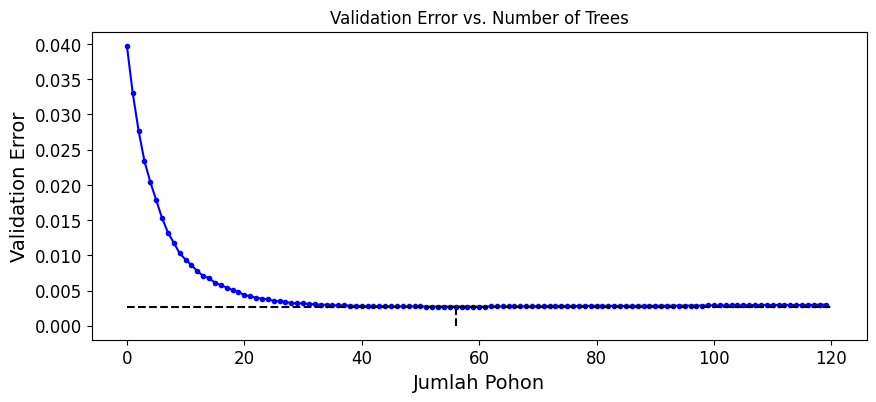

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Membuat data kuadratik untuk regresi
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X, y, random_state=49)


# Melatih Gradient Boosting Regressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train_reg, y_train_reg)

# Mencari jumlah pohon optimal dengan early stopping
errors = [mean_squared_error(y_val_reg, y_pred)
          for y_pred in gbrt.staged_predict(X_val_reg)]
bst_n_estimators = np.argmin(errors) + 1

# Melatih kembali model dengan jumlah pohon optimal
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train_reg, y_train_reg)

print("\nJumlah pohon optimal (Gradient Boosting):", bst_n_estimators)

# Plot validation error vs jumlah pohon
plt.figure(figsize=(10, 4))
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min(errors)], "k--")
plt.plot([0, 120], [min(errors), min(errors)], "k--")
plt.xlabel("Jumlah Pohon")
plt.ylabel("Validation Error")
plt.title("Validation Error vs. Number of Trees")
plt.show()

In [8]:
# CATATAN: Ini adalah implementasi manual
# meniru logika yang dijelaskan di buku.

# 1. Membagi data training utama menjadi dua subset
X_train_main, X_val_main, y_train_main, y_val_main = train_test_split(X_train, y_train, random_state=42)

# 2. Melatih beberapa model pada subset pertama
rnd_clf_stack = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf_stack = SVC(gamma="scale", probability=True, random_state=42)

rnd_clf_stack.fit(X_train_main, y_train_main)
svm_clf_stack.fit(X_train_main, y_train_main)

# 3. Membuat prediksi pada subset kedua (hold-out set)
val_pred_rnd = rnd_clf_stack.predict(X_val_main)
val_pred_svm = svm_clf_stack.predict(X_val_main)

# 4. Menggabungkan prediksi menjadi fitur baru untuk blender
blender_input_features = np.c_[val_pred_rnd, val_pred_svm]

# 5. Melatih blender (model akhir) pada fitur baru ini
# Di sini kita menggunakan Logistic Regression sebagai blender
blender = LogisticRegression(solver="lbfgs", random_state=42)
blender.fit(blender_input_features, y_val_main)

# 6. Untuk membuat prediksi pada data test,
# pertama-tama buat prediksi dari model lapisan pertama
test_pred_rnd = rnd_clf_stack.predict(X_test)
test_pred_svm = svm_clf_stack.predict(X_test)
blender_test_features = np.c_[test_pred_rnd, test_pred_svm]

# Kemudian gunakan blender untuk membuat prediksi akhir
final_predictions = blender.predict(blender_test_features)
print("\nAkurasi Stacking (manual):", accuracy_score(y_test, final_predictions))


Akurasi Stacking (manual): 0.896
